In [10]:
# Importing packages

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping

# Optuna for hyperparameter optimization
import optuna

**Objective**

This code is designed to forecast store sales 16 days into the future. The data holds sales per day collected between 2013 and July 2017, and is constructed as follows: each row describes the sales on that day for a specific store for a specific product family. The data holds information about the number of product that were on promotion that day. Other data sources provide information about national, regional or local holidays, geography and location of the stores, oil prices, and total transactions per day per store.


**Approach**

The task involves many different time-series, that is, for each pair (store number,family) we have a distinct time series. However, we will use machine-learning models to learn the dynamics of these time series, and since we believe that there are similarities between the dynamics of the different time-seires, we choose to feed our model with the entire data, categorized by store number and family, in order to help the model learn the patterns that are similar between these time series.

**Data ingestion and preparation**

The following code reads the different data sources and converts the 'date' field to datetime format. The following preliminary processing is handled:
1. rows for Christmas were missing and are added with values 0.
2. missing oil prices are filled through linear interpolation.
3. missing transactions entries are filled by sales * average sales per transaction per store.
4. holidays and events are binned (for example, all football events are binned together), and are loaded to the data frame
only for stores for which they are geographically relevant.

All these processes data sources are merged into a full data frame that contains the underlying information, from which other features are extracted.

In [11]:
# Reading in provided source data

train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv",index_col='id')
holidays_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv",index_col='id')

In [12]:
# Correct date format

train_df['date'] = pd.to_datetime(train_df['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [13]:
# Find missing dates in train_df (Christmas). Add entries for these dates with sales of 0 for each store_nbr, family.

missing_dates = pd.date_range(start=train_df['date'].min(), end=train_df['date'].max()).difference(train_df['date'])
temporary_df = train_df[(train_df['date']>='2017-02-03') & (train_df['date']<=pd.to_datetime('2017-02-03')+DateOffset(days=len(missing_dates)-1))].copy()
temporary_df[['sales','onpromotion']] = 0
for i in range(len(missing_dates)):
    temporary_df.loc[temporary_df['date']==pd.to_datetime('2017-02-03')+DateOffset(days=i),'date'] = missing_dates[i]
train_df =  pd.concat([train_df, temporary_df], axis=0)

In [14]:
# Concatenate train_df and test_df. Sort by date.
full_df = pd.concat([train_df, test_df], axis = 0)
full_df = full_df.sort_values(by=['date','store_nbr','family'],ignore_index=True)

In [15]:
# Interpolate oil prices linearly where missing.
calendar_df = pd.DataFrame(pd.date_range(start='2013-01-01', end='2017-08-15'), columns = ['date'])
oil_df = pd.merge(left=calendar_df,right=oil_df,on='date',how='left')
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate()

In [16]:
# Preparing transaction data

# Transaction data is missing for some dates.

# Calculate sum of sales per store
transactions_df = pd.merge(left=transactions_df,right=pd.DataFrame(train_df.groupby(['date','store_nbr'])['sales'].sum()).reset_index(),on=['date', 'store_nbr'],how='outer')
# Calculate sales per transaction (per day and store)
transactions_df['sales_per_transaction'] = transactions_df['sales'] / transactions_df['transactions']
# Calculate average sales per transaction per store
store_ratio = transactions_df.groupby('store_nbr')['sales_per_transaction'].mean().to_dict()
# Fill missing transactions with sales * average sales per transaction per store.
transactions_df['transactions'] = transactions_df['transactions'].fillna(transactions_df['sales']/transactions_df['store_nbr'].map(store_ratio))
transactions_df = transactions_df[['date', 'store_nbr', 'transactions']]

In [17]:
# Preparing holiday data

new_holidays_df = holidays_df[holidays_df['transferred']==False]
new_holidays_df = new_holidays_df.groupby(['date','locale','locale_name']).sum()
new_holidays_df = new_holidays_df.reset_index()

# Remove transferred holidays as they resemble workdays
new_holidays_df = holidays_df[holidays_df['transferred']==False]

# Binning football holidays first to remove '-' string from descriptions
new_holidays_df.loc[(new_holidays_df['description'].str.contains('futbol')), 'description'] = 'Futbol'

# Removing anticipated holidays because we will use future features
new_holidays_df = new_holidays_df.loc[new_holidays_df['description'].str.find('-')==-1]

# Binning local holidays
new_holidays_df.loc[(new_holidays_df['locale']=='Local') & (new_holidays_df['description'].str.contains('Fundacion')), 'description'] = 'Fundacion'
new_holidays_df.loc[(new_holidays_df['locale']=='Local') & (new_holidays_df['description'].str.contains('Cantonizacion')), 'description'] = 'Cantonizacion'
new_holidays_df.loc[(new_holidays_df['locale']=='Local') & (new_holidays_df['description'].str.contains('Independencia')), 'description'] = 'Independencia'

# Binning regional holidays
new_holidays_df.loc[(new_holidays_df['locale']=='Regional') & (new_holidays_df['description'].str.contains('Provincializacion')), 'description'] = 'Provincializacion'

# Binning national holidays
new_holidays_df.loc[(new_holidays_df['locale']=='National') & (new_holidays_df['description'].str.contains('Terremoto')), 'description'] = 'Earthquake'
new_holidays_df.loc[(new_holidays_df['locale']=='National') & (new_holidays_df['description'].str.contains('Recupero')), 'description'] = 'Work Day'
new_holidays_df['description'] = new_holidays_df['description'].str.replace('Traslado ','')

new_holidays_df = new_holidays_df.loc[new_holidays_df['description'].str.find('+')==-1]

# Joining description for more than one holiday in same location
check_df = new_holidays_df.groupby(['date','locale','locale_name'])['description'].apply(', '.join).reset_index()
new_holidays_df = new_holidays_df.drop('description', axis=1)
new_holidays_df = new_holidays_df.merge(check_df, on=['date','locale','locale_name'], how='left')
new_holidays_df = new_holidays_df.drop_duplicates(subset=['date','locale','locale_name'])

In [18]:
# Renaming type in stores_df because another type is coming soon from holidays
stores_df = stores_df.rename(columns={'type':'store_type'})

In [19]:
# Merging dataframes
full_df = pd.merge(left=full_df,right=stores_df,on='store_nbr',how='left')
full_df = pd.merge(left=full_df,right=oil_df,on='date',how='left')
full_df = pd.merge(left=full_df,right=transactions_df,on=['date','store_nbr'],how='left')
full_df = pd.merge(left=full_df,right=new_holidays_df.loc[new_holidays_df['locale']=='National',['date','description','type']],
                                    on='date',how='left')
full_df = full_df.rename(columns={'description':'national_holiday_description','type':'national_holiday_type'})
full_df = pd.merge(left=full_df,right=new_holidays_df.loc[new_holidays_df['locale']=='Regional',['date','locale_name','description','type']],
                                    left_on=['date','state'],right_on=['date','locale_name'],how='left')
full_df = full_df.rename(columns={'description':'regional_holiday_description','type':'regional_holiday_type'})
full_df = full_df.drop(axis='columns',labels='locale_name')
full_df = pd.merge(left=full_df,right=new_holidays_df.loc[new_holidays_df['locale']=='Local',['date','locale_name','description','type']],
                                    left_on=['date','city'],right_on=['date','locale_name'],how='left')
full_df = full_df.rename(columns={'description':'local_holiday_description','type':'local_holiday_type'})
full_df = full_df.drop(axis='columns',labels='locale_name')

In [20]:
# Place default value if there is no holiday.
holiday_features = ['national_holiday_description','national_holiday_type',
                'regional_holiday_description','regional_holiday_type',
                'local_holiday_description','local_holiday_type']
full_df[holiday_features] = full_df[holiday_features].fillna('No holiday')

When the full data frame is ready, we verify that each possible triplet (date,store number,family) appears exactly ones in the data frame:

In [21]:
# Sanity checks: Each pair of store_nbr, family has exactly one entry for each date.

# Each possible triple appears, because the number of possible distinct triples == number of appearing distinct triples.

x = len(set(list(zip(full_df['date'], full_df['store_nbr'], full_df['family']))))

print(full_df['date'].nunique()*full_df['store_nbr'].nunique()*full_df['family'].nunique() == x)

# Each triple appears exaxtly once.

print(x == len(list(zip(full_df['date'], full_df['store_nbr'], full_df['family']))))

# There are 54 * 33 = 1782 distinct cominations 'store_nbr', 'family'.

True
True


**Attempt: Prediction on 2017-08-15**: We will train different models to predict the sales for each of the 16 days in the test file. We will use the last date of the train file as the prediction origin.

In [22]:
prediction_date = train_df['date'].max()

**Features**

We create the following features for our model:
1. day of the month (for seasonality)
2. month (for seasonality)
3. year (in case the data is not stationary)
4. day of week (for seasonality)
5. sine and cosine with period one week (seasonality)
6. sine and cosine with period one year (seasonality)
7. sine and cosine with period one month (seasonality)
8. sine and cosine with period two weeks (seasonality due to payment cycle)
9. shifted sales (autoregressive dynamics)
10. moving averages with window size a week and a month
11. moving average of onpromotion
12. future data that is known at the forecast origin (holidays, onpromotion)


In [23]:
# Time features

full_df['day'] = full_df['date'].dt.day
full_df['month'] = full_df['date'].dt.month
full_df['year'] = full_df['date'].dt.year

full_df['day_of_week'] = full_df['date'].dt.day_of_week
full_df['sin_day_of_week'] = np.sin(2*np.pi*(full_df['day_of_week']/7))
full_df['cos_day_of_week'] = np.cos(2*np.pi*(full_df['day_of_week']/7))

full_df['sin_month_of_year'] = np.sin(2*np.pi*(full_df['date'].dt.month/12))
full_df['cos_month_of_year'] = np.cos(2*np.pi*(full_df['date'].dt.month/12))

full_df['day_of_pay_cycle'] = (full_df['day'] - 15)*(full_df['day'] >= 15)+(full_df['day']+1)*(full_df['day'] < 15)
full_df['sin_day_of_pay_cycle'] = np.sin(2*np.pi*(full_df['day_of_pay_cycle']/15))
full_df['cos_day_of_pay_cycle'] = np.cos(2*np.pi*(full_df['day_of_pay_cycle']/15))

# Lag features

# Sales from every day of the last week

shifted_sales = {
    f'sales_lag_{i}': full_df.groupby(['store_nbr', 'family'])['sales'].shift(i) 
    for i in range(1, 8)
}

full_df = pd.concat([full_df, pd.DataFrame(shifted_sales)], axis=1)

# Sales on the date one month ago

full_df['next_month'] = full_df['date']+ DateOffset(months=1)
full_df  = pd.merge(left=full_df,right=full_df[['next_month','store_nbr','family', 'sales']], 
                               left_on=['date','store_nbr', 'family'], 
                               right_on=['next_month','store_nbr','family'], 
                               how='left')
full_df = full_df.rename(columns={'sales_x':'sales','sales_y':'sales_last_month'})
full_df = full_df.drop(labels=['next_month_x','next_month_x'], axis = 1)

# Rolling averages

full_df['MA_last_week'] = full_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=7).mean())
full_df['MA_last_month'] = full_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=30).mean())

# Future features
# Leakage danger, but we assume promotions are known two weeks in advance.

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=16)
full_df['MA_future_promotions'] = full_df.groupby(['store_nbr', 'family'])['onpromotion'].transform(lambda x: x.rolling(window=indexer).mean())

In [24]:
# Creating future features

holiday_features = ['national_holiday_description','national_holiday_type',
                    'regional_holiday_description','regional_holiday_type',
                    'local_holiday_description','local_holiday_type']
future_features = holiday_features + ['onpromotion']

full_df = full_df.drop(columns=[f'{feature}_step_{i}' for feature in future_features for i in range(0, 17)], errors='ignore')

shifted_data = {
    f'{feature}_step_{i}': full_df.groupby(['store_nbr', 'family'])[f'{feature}'].shift(-i) 
    for feature in future_features for i in range(0, 17)
}

full_df = pd.concat([full_df, pd.DataFrame(shifted_data)], axis=1)

In [25]:
# Future features are also copied as _step_0.

full_df = full_df.drop(columns=future_features)

In [26]:
# Here we make the distinction between numerial and categorical features

future_categorical_features = [f'{feature}_step_{i}' for feature in holiday_features for i in range(0, 17)]
categorical_features = ['store_nbr', 'family', 'day_of_week'] # 'city', 'state', 'store_type', 'cluster'

full_df[categorical_features] = full_df[categorical_features].astype('category')
full_df[future_categorical_features] = full_df[future_categorical_features].astype('category')

sales_features = [f'sales_lag_{i}' for i in range(1, 8)]
numerical_features = ['dcoilwtico', 'transactions',  
                      'day', 'month', 'year', 
                      'sin_day_of_week', 'cos_day_of_week', 'sin_month_of_year', 'cos_month_of_year', 
                      'day_of_pay_cycle', 'sin_day_of_pay_cycle', 'cos_day_of_pay_cycle', 
                      'sales_last_month', 'MA_last_week', 'MA_last_month',
                      'MA_future_promotions'] + sales_features

feature_list = []

for i in range(1, 17):
    feature_list.append(numerical_features + categorical_features 
                        + [f'{feature}_step_{j}' for feature in holiday_features for j in range(i-1, min(i+5,17))]
                        + [f'onpromotion_step_{i}'])

<Axes: xlabel='sales_lag_1', ylabel='sales'>

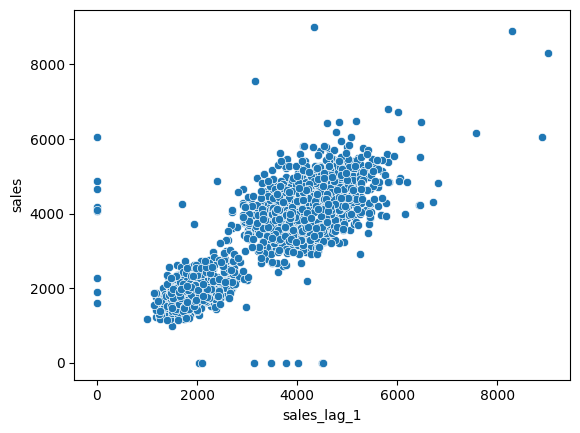

In [73]:

str_nbr = 7
fml = 'BEVERAGES'

sns.scatterplot(data = full_df[(full_df['store_nbr']== str_nbr)& (full_df['family']== fml)], x='sales_lag_1', y='sales')
#sns.scatterplot(data = full_df[(full_df['store_nbr']== str_nbr)& (full_df['family']== fml)], x='sales_lag_7', y='sales')
# sns.scatterplot(data = full_df[(full_df['store_nbr']== str_nbr)& (full_df['family']== fml)], x='dcoilwtico', y='sales')

The figure above motivates the use of the shifted sales. There is clearly a strong positive correlation between yesterday's sales and today's. This suggests that there might be an autoregressice component to the dynamics. This feature, and others, are further justified below when the F-score is computed.

**Target**

The objective is to forecast 16 days into the future. To this end, we will train 16 different models, one for each horizon. This is done by building a full dataframe which is composed of the features and target for all models. The features were discussed above, and the targets for each date are the sales in the 16 days that follow (negtively shifted sales).

In [30]:
# Create target data

full_df = full_df.drop(columns=[f'sales_step_{i}' for i in range(1, 17)], errors='ignore')

shifted_data = {
    f'sales_step_{i}': full_df.groupby(['store_nbr', 'family'])['sales'].shift(-i) 
    for i in range(1, 17)
}

full_df = pd.concat([full_df, pd.DataFrame(shifted_data)], axis=1)

# Take log on target

full_df['log_sales'] = np.log(1+full_df['sales'])
for i in range(1,17):
    full_df[f'log_sales_step_{i}'] = np.log(1+full_df[f'sales_step_{i}'])

<ipython-input-30-54113689e063>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f'sales_step_{i}': full_df.groupby(['store_nbr', 'family'])['sales'].shift(-i)


In [31]:
# Filter set to remove rows with missing features or targets
subset_na = [f'log_sales_step_{i}' for i in range(1,17)]+numerical_features
X = full_df.dropna(axis=0,subset=subset_na)

In [32]:
# Restrict data

# X = X[X['year']>2014]

In [33]:
# Target
target_list = [f'log_sales_step_{i}' for i in range(1,17)]
y = X[target_list]

In [34]:
# Train test split

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

In [35]:
# Idea:
# 1. Train different types of models
# 2. Hyperparameter optimization
# 3. After having chosen good hyperparameters, train each chosen model on a separate split.
# 4. Combine (probably just average) models.

In [36]:
# Hyperparameter optimization for xgb
# Ideally, we would find the optimal hyperparameters for each model. This takes too much time.  Choose 7.

# def objective_xgb(trial):
#     params={
#         'max_depth':trial.suggest_int('max_depth',6,15),
#         'min_child_weight':trial.suggest_float('min_child_weight',1e-2,100,log=True),
#         'subsample':trial.suggest_float('subsample',0.5,1),
#         'learning_rate':trial.suggest_float('learning_rate',0.01,0.3,log=True),
#         'colsample_bytree':trial.suggest_float('colsample_bytree',0.5,1)
#     }
#     model = XGBRegressor(
#         **params,
#         n_estimators=1000,
#         early_stopping_rounds=5,
#         eval_metric='rmse',
#         tree_method='hist',
#         enable_categorical = True
#     )
#     model.fit(
#         X_train[feature_list[7]], 
#         y_train[f'log_sales_step_8'], 
#         eval_set=[(X_valid[feature_list[7]], y_valid[f'log_sales_step_8'])], 
#         verbose = 0)
#     preds = model.predict(X_valid[feature_list[7]])
#     return mean_squared_error(y_valid[f'log_sales_step_8'],preds)

# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb,n_trials=50)
# best_params_xgb = study_xgb.best_params
# print(best_params_xgb)

In [37]:
# Result of hyperparameter optimization for xgb

# With 50 iterations:

# best_params_xgb={
#      'max_depth': 11, 
#      'min_child_weight': 5.716785274742769, 
#      'subsample': 0.9234688380913888, 
#      'learning_rate': 0.040487705693284505, 
#      'colsample_bytree': 0.6294748159852215
#     }

# With 35 iterations:

# best_params_xgb={
#         'max_depth':14,
#         'min_child_weight':4.990640605482132,
#         'subsample':0.8814379905410369,
#         'learning_rate':0.03259546572,
#         'colsample_bytree':0.8437365655068993
#     }

# Heuristic defaults:

best_params_xgb={
    'max_depth': 8,
    'min_child_weight': 5,
    'subsample': 0.8,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8
    }

In [38]:
# Hyperparameter optimization for lgbm
# Ideally, we would find the optimal hyperparameters for each model. This takes too much time.  Choose 7.

# from lightgbm import LGBMRegressor
# from lightgbm.callback import early_stopping

# def objective_lgbm(trial):
#     params={
#         'num_leaves':trial.suggest_int('num_leaves',30,150),
#         'min_child_weight':trial.suggest_float('min_child_weight',1e-3,100,log=True),
#         'subsample':trial.suggest_float('subsample',0.5,1),
#         'learning_rate':trial.suggest_float('learning_rate',0.01,0.3,log=True),
#         'colsample_bytree':trial.suggest_float('colsample_bytree',0.5,1)
#     }
#     model = LGBMRegressor(
#         **params,
#         n_estimators=1000
#     )
#     model.fit(
#         X_train[feature_list[7]],
#         y_train[f'log_sales_step_8'],
#         eval_set=[(X_valid[feature_list[7]], y_valid[f'log_sales_step_8'])],
#         callbacks=[early_stopping(stopping_rounds=5)],
#         eval_metric='rmse'
#     )
#     preds = model.predict(X_valid[feature_list[7]])
#     return mean_squared_error(y_valid[f'log_sales_step_8'],preds)

# study_lgbm = optuna.create_study(direction='minimize')
# study_lgbm.optimize(objective_lgbm,n_trials=50)
# best_params_lgbm = study_lgbm.best_params
# print(best_params_lgbm)

In [39]:
# Result of hyperparameter optimization for lgbm

# With 50 iterations: 

# best_params_lgbm={
#     'num_leaves': 141, 
#      'min_child_weight': 0.0013941886951568947, 
#      'subsample': 0.892295408305398, 
#      'learning_rate': 0.10205166138848568, 
#      'colsample_bytree': 0.6582560601895524
#     }

# With 35 iterations:

# best_params_lgbm={
#         'num_leaves':141,
#         'min_child_weight':0.02362221828066401,
#         'subsample':0.6927354612523271,
#         'learning_rate':0.10616785590747908,
#         'colsample_bytree':0.7840718293546729
#     }

# Heuristic defaults:

best_params_lgbm={
        'num_leaves':31,
        'min_child_weight':5,
        'subsample':0.8,
        'learning_rate':0.05,
        'colsample_bytree':0.8
    }

In [40]:
# Hyperparameter optimization for cat
# Ideally, we would find the optimal hyperparameters for each model. This takes too much time. Choose 7.

# #pip install optuna-integration[catboost]
# #from optuna.integration import CatBoostPruningCallback

#def objective_cat(trial):
#    params={
#        'depth':trial.suggest_int('depth',4,10),
#        'random_strength':trial.suggest_float('random_strength',1e-9,10,log=True),
#        'bagging_temperature':trial.suggest_float('bagging_temperature',0,10),
#        'learning_rate':trial.suggest_float('learning_rate',0.01,0.3,log=True),
#        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True)
#    }
#    model = CatBoostRegressor(
#        **params,
#        loss_function='RMSE',
#        task_type="GPU",        # <-- enable GPU
#        devices='0,1',
#        iterations=500
#    )
#    # pruning_callback = CatBoostPruningCallback(trial, 'RMSE')
#    model.fit(
#        X_train[feature_list[7]],
#        y_train[f'log_sales_step_8'],
#        cat_features = list(set(categorical_features+future_categorical_features) & set(feature_list[7])),
#        eval_set=(X_valid[feature_list[7]], y_valid[f'log_sales_step_8']),
#        early_stopping_rounds=5,
#        # callbacks=[pruning_callback],
#        verbose = 50)
#    preds = model.predict(X_valid[feature_list[7]])
#    return mean_squared_error(y_valid[f'log_sales_step_8'],preds)

# #study_cat = optuna.create_study(direction='minimize',pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
#study_cat = optuna.create_study(direction='minimize')
#study_cat.optimize(objective_cat,n_trials=50)
#best_params_cat = study_cat.best_params
#print(best_params_cat)

In [41]:
# Result of hyperparameter optimization for catboost

# With 50 iterations:

# best_params_cat={
#        'depth':9,
#        'random_strength':0.05626974752238471,
#        'bagging_temperature':0.09747368919292904,
#        'learning_rate':0.236652999497516,
#        'l2_leaf_reg':4.580022980524382}

# Heuristic defaults:

best_params_cat={
       'depth':8,
       'random_strength':1,
       'bagging_temperature':1,
       'learning_rate':0.05,
       'l2_leaf_reg':3}

**Training**

Here we train 16 models for 16 different horizons. We use three booting models: XG boost, light gradient boosting model, and cat boost - and we average these with weights that are related with the validation score of the models.

In [42]:
# Training xgboost. We do one split per type of model, to save time.

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

models_xgb = {}
weights_xgb = []
for i in range(1,17):
    print(i)
    model = XGBRegressor(
        **best_params_xgb,
        n_estimators=1000,
        tree_method='hist',     
        device = 'cuda',
        early_stopping_rounds=5,
        eval_metric='rmse',
        enable_categorical = True
    )
    model.fit(
        X_train[feature_list[i-1]], 
        y_train[f'log_sales_step_{i}'], 
        eval_set=[(X_valid[feature_list[i-1]], y_valid[f'log_sales_step_{i}'])], 
        verbose = 0)
    preds = model.predict(X_valid[feature_list[i-1]])
    weights_xgb.append(1/mean_squared_error(y_valid[f'log_sales_step_{i}'],preds))
    models_xgb[i] = model

1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:49:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [43]:
# Train lightgbm. We do one split per type of model, to save time.

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

models_lgbm = {}
weights_lgbm = []
for i in range(1, 17):
    print(i)
    model = LGBMRegressor(
        **best_params_lgbm,    
        device='gpu',           
        gpu_platform_id=0,      
        gpu_device_id=0, 
        n_estimators=1000
    )
    model.fit(
        X_train[feature_list[i - 1]],
        y_train[f'log_sales_step_{i}'],
        eval_set=[(X_valid[feature_list[i - 1]], y_valid[f'log_sales_step_{i}'])],
        callbacks=[early_stopping(stopping_rounds=5)],
        eval_metric='rmse'
    )
    preds = model.predict(X_valid[feature_list[i-1]])
    weights_lgbm.append(1/mean_squared_error(y_valid[f'log_sales_step_{i}'],preds))
    models_lgbm[i] = model

1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3985
[LightGBM] [Info] Number of data points in the train set: 2194533, number of used features: 63
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (58.60 MB) transferred to GPU in 0.048721 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.936822
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.363062	valid_0's l2: 0.131814
2
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3995
[LightGBM] [Info] Number of data points in the train set: 2194533, number of used features: 63
[LightGBM] [Info] Using request

In [44]:
# Train catboost. We do one split per type of model, to save time.

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

models_cat = {}
weights_cat = []
for i in range(1,17):
    print(i)
    model = CatBoostRegressor(
        **best_params_cat,
        loss_function='RMSE',
        task_type="GPU",        # <-- enable GPU
        devices='0',            # use first GPU
        iterations=1000
    )
    model.fit(
        X_train[feature_list[i-1]],
        y_train[f'log_sales_step_{i}'],
        cat_features = list(set(categorical_features+future_categorical_features) & set(feature_list[i-1])),
        eval_set=(X_valid[feature_list[i-1]], y_valid[f'log_sales_step_{i}']),
        early_stopping_rounds = 5,
        verbose = 50)
    preds = model.predict(X_valid[feature_list[i-1]])
    weights_cat.append(1/mean_squared_error(y_valid[f'log_sales_step_{i}'],preds))
    models_cat[i] = model

1
0:	learn: 2.5678486	test: 2.5665269	best: 2.5665269 (0)	total: 1.31s	remaining: 21m 51s
50:	learn: 0.5046357	test: 0.5035567	best: 0.5035567 (50)	total: 50.6s	remaining: 15m 41s
100:	learn: 0.4313039	test: 0.4304696	best: 0.4304696 (100)	total: 1m 42s	remaining: 15m 13s
150:	learn: 0.4175249	test: 0.4169159	best: 0.4169159 (150)	total: 2m 33s	remaining: 14m 22s
200:	learn: 0.4093828	test: 0.4087046	best: 0.4087046 (200)	total: 3m 23s	remaining: 13m 30s
250:	learn: 0.4025652	test: 0.4019681	best: 0.4019681 (250)	total: 4m 14s	remaining: 12m 40s
300:	learn: 0.3976321	test: 0.3972179	best: 0.3972179 (300)	total: 5m 7s	remaining: 11m 54s
350:	learn: 0.3942132	test: 0.3939696	best: 0.3939696 (350)	total: 5m 56s	remaining: 10m 59s
400:	learn: 0.3906676	test: 0.3905547	best: 0.3905547 (400)	total: 6m 46s	remaining: 10m 6s
450:	learn: 0.3879986	test: 0.3880675	best: 0.3880675 (450)	total: 7m 34s	remaining: 9m 12s
500:	learn: 0.3857492	test: 0.3859550	best: 0.3859550 (500)	total: 8m 21s	remai

In [45]:
print(weights_xgb)
print(weights_lgbm)
print(weights_cat)

[8.0349719270871, 7.780833359221747, 7.539410170323728, 7.423109541128323, 7.249566271663753, 7.170387077363774, 7.0552715415661265, 6.9384611869434805, 6.844148562357308, 6.747636956758833, 6.749324165452486, 6.688422457271872, 6.6216208054146675, 6.655718651760617, 6.517150914439825, 6.526293104444178]
[7.586426188263154, 7.199883014539406, 6.990720958577355, 6.787771541225649, 6.664283642262349, 6.471033939504304, 6.372598803894383, 6.1457540241075606, 6.1003049024997695, 6.060402503068709, 6.025727297733269, 5.960425803993238, 5.877398232499319, 5.810241290385886, 5.774534305274962, 5.759896936515618]
[7.151074679843582, 6.836872064354726, 6.507299870924281, 6.306824077693679, 6.1226342349272596, 5.952131159328163, 5.7671483090260685, 5.548984705265134, 5.4558364810633515, 5.329180935644827, 5.28181524619822, 5.2161410391554694, 5.15871084037304, 5.056687940615795, 4.931748698785582, 4.878611101156044]


In [46]:
# computing the weights for the weighted average

weights_xgb = np.array(weights_xgb)
weights_lgbm = np.array(weights_lgbm)
weights_cat = np.array(weights_cat)

sum_weights = weights_xgb+weights_lgbm+weights_cat

weights_xgb = weights_xgb/sum_weights
weights_lgbm = weights_lgbm/sum_weights
weights_cat = weights_cat/sum_weights

In [47]:
# Predict results on training set.

comparison_df = full_df.loc[(full_df['year']==2017) & (full_df['date'] <= prediction_date),:]

for model_type in ('xgb', 'lgbm', 'cat'):
    if model_type == 'xgb':
        models = models_xgb
    elif model_type == 'lgbm':
        models = models_lgbm
    elif model_type == 'cat':
        models = models_cat
    for i in models.keys():
        print(i)
        y = models[i].predict(comparison_df[feature_list[i-1]])
        y = np.exp(y)-1
        y = np.clip(y, a_min = 0, a_max=None)
        comparison_df[f'{model_type}_pred_sales_step_{i}'] = y

1


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


2


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


3


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


4


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


5


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


6


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


7


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


8


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


9


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


10


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


11


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


12


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


13


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


14


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


15


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


16


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


1


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


2


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


3


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


4


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


5


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


6


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


7


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


8


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


9


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


10


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


11


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


12


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


13


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


14


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


15


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


16


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


1


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


2


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


3


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


4


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


5


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


6


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


7


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


8


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


9


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


10


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


11


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


12


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


13


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


14


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


15


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


16


<ipython-input-47-a2d4806f80ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'{model_type}_pred_sales_step_{i}'] = y


In [48]:
comparison_df.to_csv('/kaggle/working/comparison_df.csv',index=True)

In [49]:
# Average predictions weighted by the performance-based weights

for i in range(1,17):
    comparison_df[f'avg_pred_sales_step_{i}'] = comparison_df[[f'xgb_pred_sales_step_{i}',
                                                              f'lgbm_pred_sales_step_{i}',
                                                              f'cat_pred_sales_step_{i}']].mean(axis=1)
    comparison_df[f'w_avg_pred_sales_step_{i}'] = weights_xgb[i-1]*comparison_df[f'xgb_pred_sales_step_{i}']+ weights_lgbm[i-1]*comparison_df[f'lgbm_pred_sales_step_{i}']+ weights_cat[i-1]*comparison_df[f'cat_pred_sales_step_{i}']

<ipython-input-49-8f8f0de68682>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'avg_pred_sales_step_{i}'] = comparison_df[[f'xgb_pred_sales_step_{i}',
<ipython-input-49-8f8f0de68682>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df[f'w_avg_pred_sales_step_{i}'] = weights_xgb[i-1]*comparison_df[f'xgb_pred_sales_step_{i}']+ weights_lgbm[i-1]*comparison_df[f'lgbm_pred_sales_step_{i}']+ weights_cat[i-1]*comparison_df[f'cat_pred_sales_step_{i}']
<ipython-input-49-8f8f0de68682>:4: S

In [50]:
# Examples

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

comparison_df.head()
comparison_df[comparison_df['date']=='2017-08-22'].head()

,date,store_nbr,family,sales,city,state,store_type,cluster,dcoilwtico,transactions,day,month,year,day_of_week,sin_day_of_week,cos_day_of_week,sin_month_of_year,cos_month_of_year,day_of_pay_cycle,sin_day_of_pay_cycle,cos_day_of_pay_cycle,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,next_month_y,sales_last_month,MA_last_week,MA_last_month,MA_future_promotions,national_holiday_description_step_0,national_holiday_description_step_1,national_holiday_description_step_2,national_holiday_description_step_3,national_holiday_description_step_4,national_holiday_description_step_5,national_holiday_description_step_6,national_holiday_description_step_7,national_holiday_description_step_8,national_holiday_description_step_9,national_holiday_description_step_10,national_holiday_description_step_11,national_holiday_description_step_12,national_holiday_description_step_13,national_holiday_description_step_14,national_holiday_description_step_15,national_holiday_description_step_16,national_holiday_type_step_0,national_holiday_type_step_1,national_holiday_type_step_2,national_holiday_type_step_3,national_holiday_type_step_4,national_holiday_type_step_5,national_holiday_type_step_6,national_holiday_type_step_7,national_holiday_type_step_8,national_holiday_type_step_9,national_holiday_type_step_10,national_holiday_type_step_11,national_holiday_type_step_12,national_holiday_type_step_13,national_holiday_type_step_14,national_holiday_type_step_15,national_holiday_type_step_16,regional_holiday_description_step_0,regional_holiday_description_step_1,regional_holiday_description_step_2,regional_holiday_description_step_3,regional_holiday_description_step_4,regional_holiday_description_step_5,regional_holiday_description_step_6,regional_holiday_description_step_7,regional_holiday_description_step_8,regional_holiday_description_step_9,regional_holiday_description_step_10,regional_holiday_description_step_11,regional_holiday_description_step_12,regional_holiday_description_step_13,regional_holiday_description_step_14,regional_holiday_description_step_15,regional_holiday_description_step_16,regional_holiday_type_step_0,regional_holiday_type_step_1,regional_holiday_type_step_2,regional_holiday_type_step_3,regional_holiday_type_step_4,regional_holiday_type_step_5,regional_holiday_type_step_6,regional_holiday_type_step_7,regional_holiday_type_step_8,regional_holiday_type_step_9,regional_holiday_type_step_10,regional_holiday_type_step_11,regional_holiday_type_step_12,regional_holiday_type_step_13,regional_holiday_type_step_14,regional_holiday_type_step_15,regional_holiday_type_step_16,local_holiday_description_step_0,local_holiday_description_step_1,local_holiday_description_step_2,local_holiday_description_step_3,local_holiday_description_step_4,local_holiday_description_step_5,local_holiday_description_step_6,local_holiday_description_step_7,local_holiday_description_step_8,local_holiday_description_step_9,local_holiday_description_step_10,local_holiday_description_step_11,local_holiday_description_step_12,local_holiday_description_step_13,local_holiday_description_step_14,local_holiday_description_step_15,local_holiday_description_step_16,local_holiday_type_step_0,local_holiday_type_step_1,local_holiday_type_step_2,local_holiday_type_step_3,local_holiday_type_step_4,local_holiday_type_step_5,local_holiday_type_step_6,local_holiday_type_step_7,local_holiday_type_step_8,local_holiday_type_step_9,local_holiday_type_step_10,local_holiday_type_step_11,local_holiday_type_step_12,local_holiday_type_step_13,local_holiday_type_step_14,local_holiday_type_step_15,local_holiday_type_step_16,onpromotion_step_0,onpromotion_step_1,onpromotion_step_2,onpromotion_step_3,onpromotion_step_4,onpromotion_step_5,onpromotion_step_6,onpromotion_step_7,onpromotion_step_8,onpromotion_step_9,onpromotion_step_10,onpromotion_step_11,onpromotion_step_12,onpromotion_step_13,onpromotion_step_14,onpromotion_step_15,onpromotion_step_16,sales_step_1,sal

The following cell sets identifies stores and families that didn't sell any product during 2017, and then sets the predictions for these time-series to 0. The prediction should give negligible predictios anyway, but the real values are most likely 0 so we use that.

In [52]:
# Predict 0 if there were no sales in 2017 for a store_nbr, family

no_sales_2017_df = comparison_df.groupby(['store_nbr', 'family'])[['sales']].sum()
no_sales_2017_df = no_sales_2017_df.reset_index()
no_sales_2017_df = no_sales_2017_df.rename(columns={'sales':'sum_2017_sales'})
no_sales_2017_df = no_sales_2017_df[no_sales_2017_df['sum_2017_sales']==0]

comparison_df = pd.merge(left=comparison_df,
                         right=no_sales_2017_df[['store_nbr','family','sum_2017_sales']],
                         on=['store_nbr','family'],
                         how='left')

for pred_type in ('avg', 'w_avg', 'xgb', 'lgbm', 'cat'):
    for i in range(1,17):
        comparison_df[f'{pred_type}_pred_sales_step_{i}'] = comparison_df['sum_2017_sales'].fillna(comparison_df[f'{pred_type}_pred_sales_step_{i}'])

<ipython-input-52-3ef98f0bc064>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_sales_2017_df = comparison_df.groupby(['store_nbr', 'family'])[['sales']].sum()


In [53]:
# Transpose predictions and join to test_df

prediction_df = comparison_df[comparison_df['date']== prediction_date]
prediction_df = prediction_df[['store_nbr', 'family'] 
                                +[f'avg_pred_sales_step_{i}' for i in range(1,17)]
                                +[f'w_avg_pred_sales_step_{i}' for i in range(1,17)]
                                +[f'xgb_pred_sales_step_{i}' for i in range(1,17)]
                                +[f'lgbm_pred_sales_step_{i}' for i in range(1,17)]
                                +[f'cat_pred_sales_step_{i}' for i in range(1,17)]]

# Merging predicted sales data from prediction_date
result_df = test_df.reset_index()
result_df = pd.merge(left=result_df,
                     right=prediction_df,
                     on=['store_nbr', 'family'],how='left')

# Choosing i-th prediction on day i + prediction_date
result_df['difference'] = (result_df['date']-pd.to_datetime(prediction_date)).dt.days

for pred_type in ('avg', 'w_avg', 'xgb', 'lgbm', 'cat'):
    col_names = result_df['difference'].astype(str).radd(f'{pred_type}_pred_sales_step_')
    col_codes, unique_cols = pd.factorize(col_names)
    matrix = result_df[unique_cols].to_numpy()
    result_df[f'{pred_type}_pred_sales'] = matrix[np.arange(len(result_df)), col_codes]

**Examples**

In [54]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

result_df.tail()

,id,date,store_nbr,family,onpromotion,avg_pred_sales_step_1,avg_pred_sales_step_2,avg_pred_sales_step_3,avg_pred_sales_step_4,avg_pred_sales_step_5,avg_pred_sales_step_6,avg_pred_sales_step_7,avg_pred_sales_step_8,avg_pred_sales_step_9,avg_pred_sales_step_10,avg_pred_sales_step_11,avg_pred_sales_step_12,avg_pred_sales_step_13,avg_pred_sales_step_14,avg_pred_sales_step_15,avg_pred_sales_step_16,w_avg_pred_sales_step_1,w_avg_pred_sales_step_2,w_avg_pred_sales_step_3,w_avg_pred_sales_step_4,w_avg_pred_sales_step_5,w_avg_pred_sales_step_6,w_avg_pred_sales_step_7,w_avg_pred_sales_step_8,w_avg_pred_sales_step_9,w_avg_pred_sales_step_10,w_avg_pred_sales_step_11,w_avg_pred_sales_step_12,w_avg_pred_sales_step_13,w_avg_pred_sales_step_14,w_avg_pred_sales_step_15,w_avg_pred_sales_step_16,xgb_pred_sales_step_1,xgb_pred_sales_step_2,xgb_pred_sales_step_3,xgb_pred_sales_step_4,xgb_pred_sales_step_5,xgb_pred_sales_step_6,xgb_pred_sales_step_7,xgb_pred_sales_step_8,xgb_pred_sales_step_9,xgb_pred_sales_step_10,xgb_pred_sales_step_11,xgb_pred_sales_step_12,xgb_pred_sales_step_13,xgb_pred_sales_step_14,xgb_pred_sales_step_15,xgb_pred_sales_step_16,lgbm_pred_sales_step_1,lgbm_pred_sales_step_2,lgbm_pred_sales_step_3,lgbm_pred_sales_step_4,lgbm_pred_sales_step_5,lgbm_pred_sales_step_6,lgbm_pred_sales_step_7,lgbm_pred_sales_step_8,lgbm_pred_sales_step_9,lgbm_pred_sales_step_10,lgbm_pred_sales_step_11,lgbm_pred_sales_step_12,lgbm_pred_sales_step_13,lgbm_pred_sales_step_14,lgbm_pred_sales_step_15,lgbm_pred_sales_step_16,cat_pred_sales_step_1,cat_pred_sales_step_2,cat_pred_sales_step_3,cat_pred_sales_step_4,cat_pred_sales_step_5,cat_pred_sales_step_6,cat_pred_sales_step_7,cat_pred_sales_step_8,cat_pred_sales_step_9,cat_pred_sales_step_10,cat_pred_sales_step_11,cat_pred_sales_step_12,cat_pred_sales_step_13,cat_pred_sales_step_14,cat_pred_sales_step_15,cat_pred_sales_step_16,difference,avg_pred_sales,w_avg_pred_sales,xgb_pred_sales,lgbm_pred_sales,cat_pred_sales
28507,3029395,2017-08-31,9,POULTRY,1,334.592824,300.803056,416.686530,419.384882,470.475717,317.339877,331.990460,293.576403,277.074058,428.242257,403.951362,441.265527,287.943686,302.628177,317.378492,335.107667,334.613692,301.457805,416.468013,420.490285,471.649944,318.097580,332.098793,293.465176,277.614751,427.688540,405.380138,442.889795,288.601906,303.134884,317.394072,337.484405,339.317932,313.711548,406.556488,438.292297,485.065399,329.193176,341.683807,289.715790,287.514099,425.224823,413.935028,462.678589,291.700836,309.754791,320.436951,365.015137,326.090828,306.587870,428.805164,422.658174,483.557833,318.121932,314.802066,299.092201,270.021496,420.361089,418.936920,437.895194,296.467987,299.288221,311.943481,325.483344,338.369710,282.109751,414.697938,397.204175,442.803918,304.704524,339.485506,291.921217,273.686578,439.140859,378.982137,423.222798,275.662234,298.841519,319.755044,314.824522,16,335.107667,337.484405,365.015137,325.483344,314.824522
28508,3029396,2017-08-31,9,PREPARED FOODS,0,108.367973,99.727519,101.155874,129.041318,133.004349,103.363518,95.092629,94.668240,95.569518,101.018846,124.431119,125.668750,94.876926,98.037842,95.913015,103.237527,108.194828,99.729437,100.923694,129.041849,133.170868,103.423091,95.011038,94.431161,95.240752,100.313795,124.045684,125.338216,94.432629,97.670970,95.983042,103.167480,102.358017,99.526192,94.961098,127.147858,135.384979,104.186455,93.639244,91.013382,92.084869,90.984909,120.728897,123.503181,88.039955,95.520233,94.346855,99.721329,111.513127,100.366288,104.277913,133.458620,134.211144,103.681004,95.598088,95.775466,93.689528,102.995055,122.378816,122.018760,97.877690,94.849148,100.290331,108.447188,111.232775,99.290077,104.228612,126.517477,129.416924,102.223095,96.040556,97.215873,100.934157,109.076573,130.185644,131.484310,98.713133,103.744146,93.101857,101.544064,16,103.237527,103.167480,99.721329,108.447188,101.544064
28509,3029397,2017-08-31,9,PRODUCE,1,1776.004670,1078.064707,1250.090976,1554.261495,1788.495006,1365.720595

<Figure size 640x480 with 0 Axes>

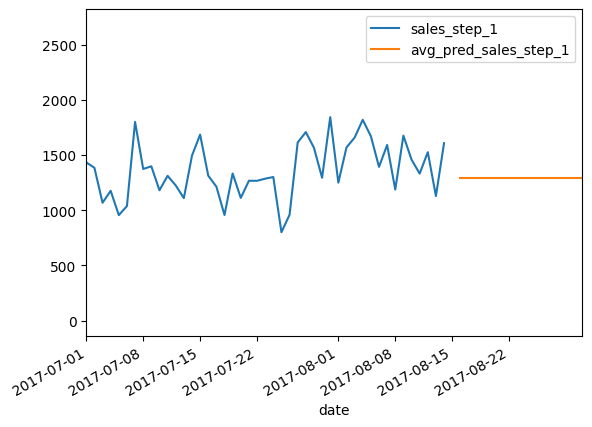

In [56]:
str_nbr = 10
fml = 'BEVERAGES'

train_condition = (full_df['store_nbr']==str_nbr) & (full_df['family']==fml)
test_condition = (result_df['store_nbr']==str_nbr) & (result_df['family']==fml)

plt.figure()
axs = full_df.loc[train_condition,:].plot(x='date', y='sales_step_1',xlim = ('2017-07-01','2017-08-31')) #, ylim=(0,20)
axs = result_df.loc[test_condition,:].plot(x='date', y='avg_pred_sales_step_1', ax=axs)
#axs = full_df.loc[train_condition,:].plot(x='date', y='MA_last_month', ax=axs) #
#axs = result_df.loc[test_condition,:].plot(x='date', y='predicted_sales', ax=axs) #
plt.show()

**Evaluation**

Here, we compute the F-score of different features to help understand the contribution of each feature to the performance. It helps us understand if any features are redundant, which helps simplify the model and avoid overfitting. It also reinforces our trust in the model if we believe that the order of feature importance makes sense.

<Figure size 640x480 with 0 Axes>

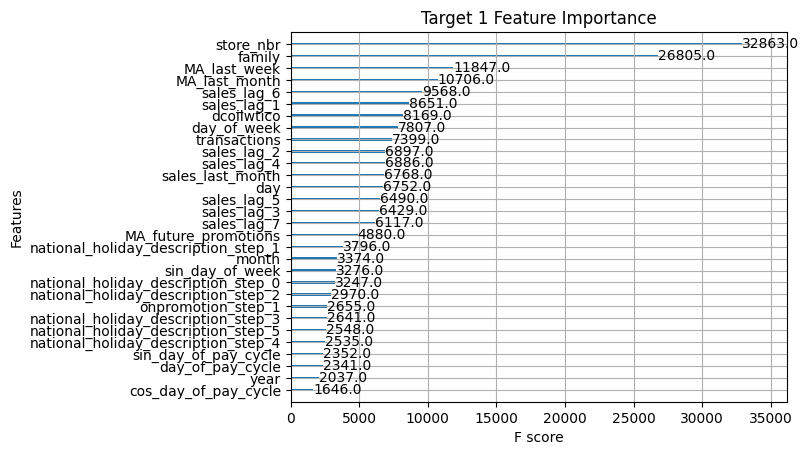

<Figure size 640x480 with 0 Axes>

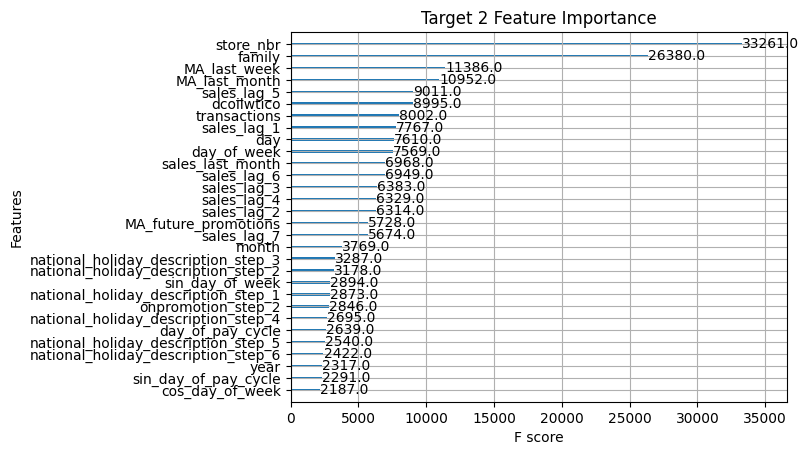

<Figure size 640x480 with 0 Axes>

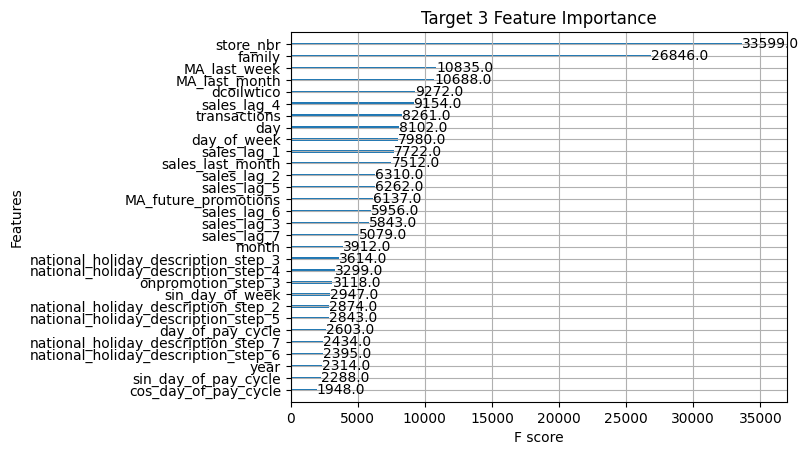

<Figure size 640x480 with 0 Axes>

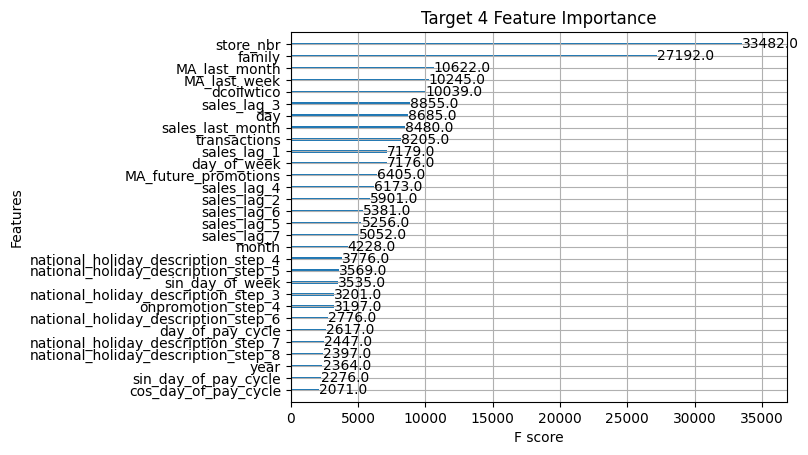

<Figure size 640x480 with 0 Axes>

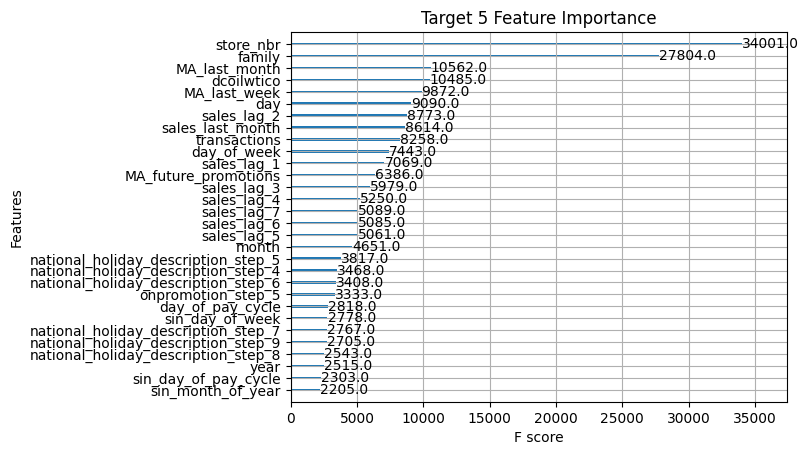

<Figure size 640x480 with 0 Axes>

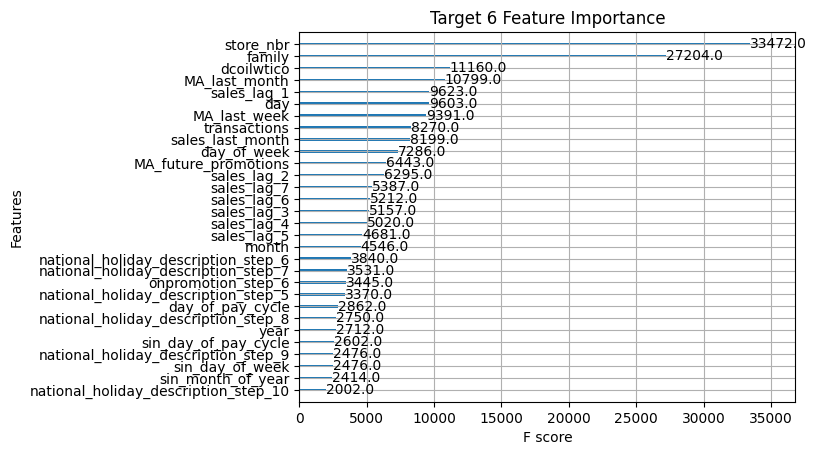

<Figure size 640x480 with 0 Axes>

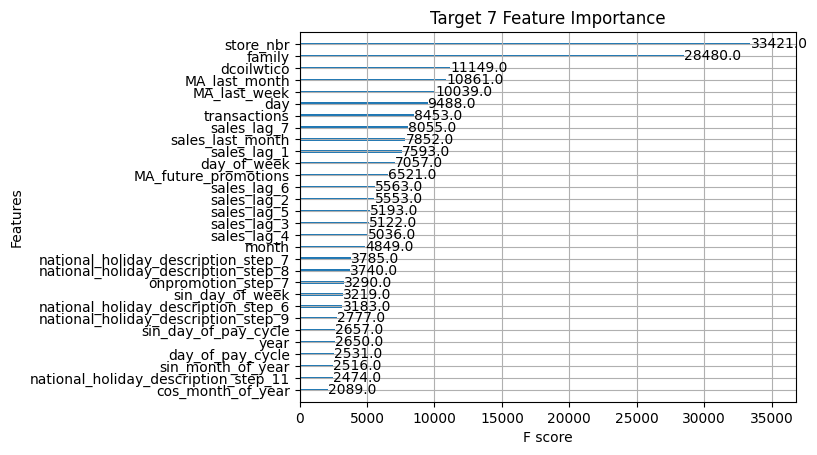

<Figure size 640x480 with 0 Axes>

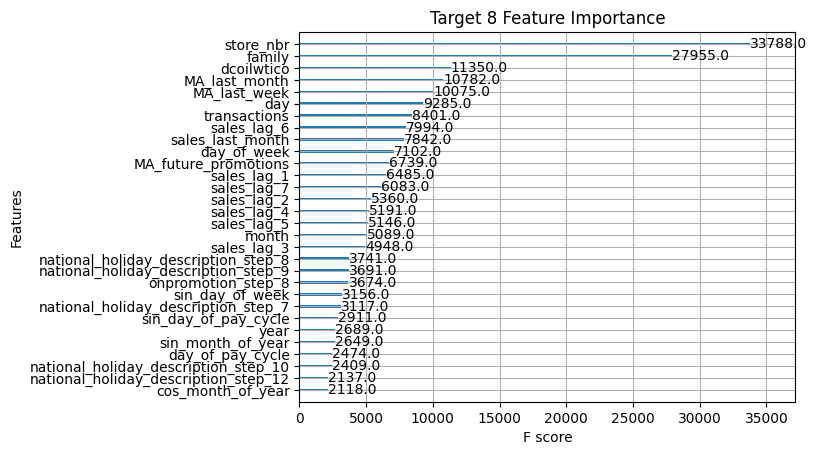

<Figure size 640x480 with 0 Axes>

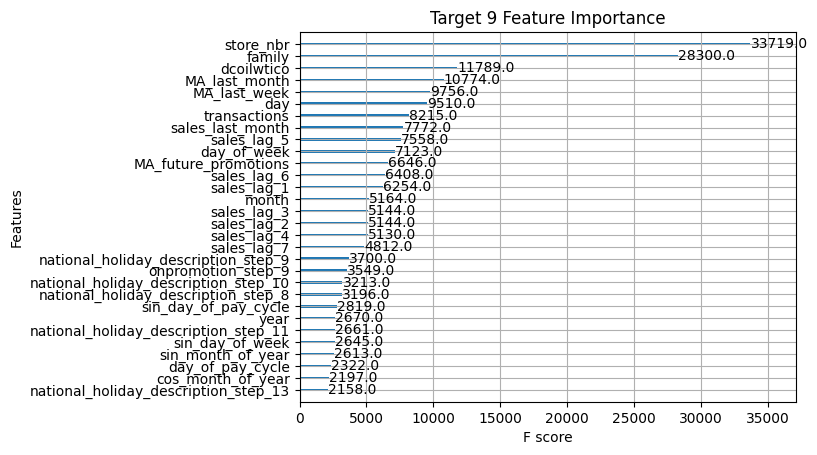

<Figure size 640x480 with 0 Axes>

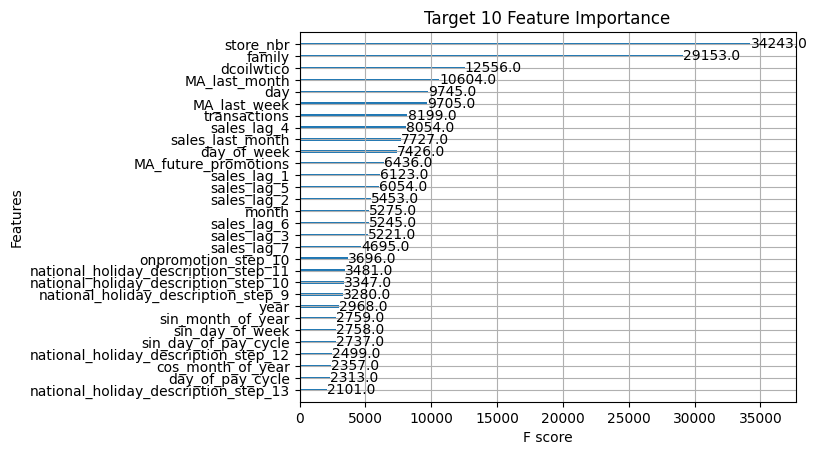

<Figure size 640x480 with 0 Axes>

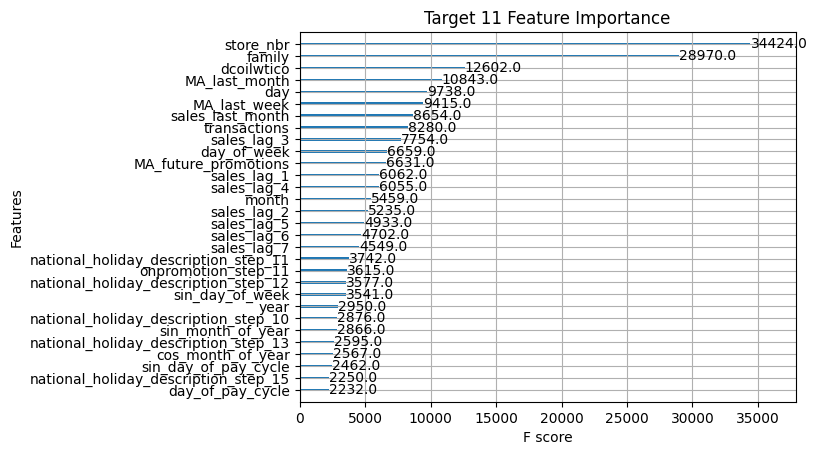

<Figure size 640x480 with 0 Axes>

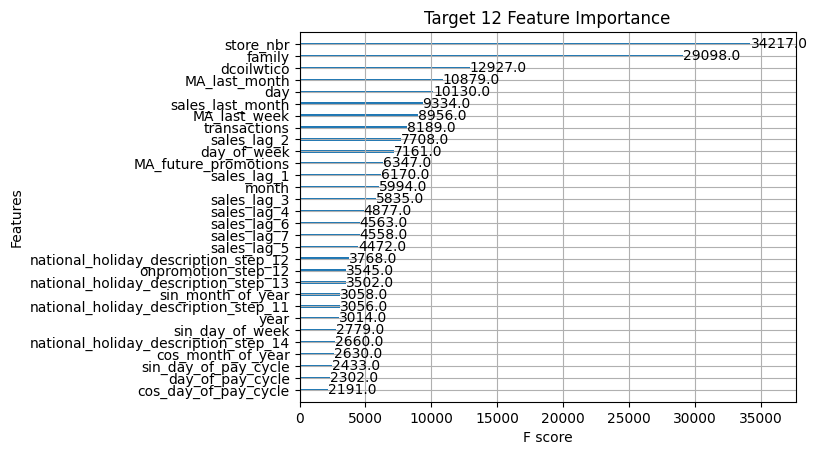

<Figure size 640x480 with 0 Axes>

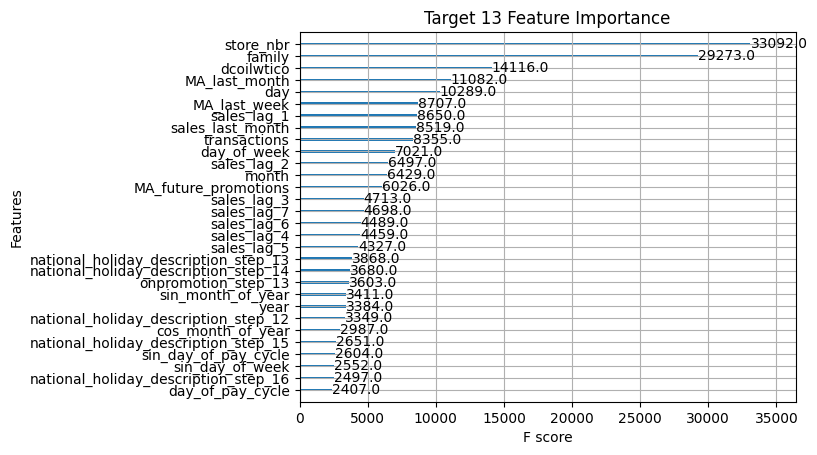

<Figure size 640x480 with 0 Axes>

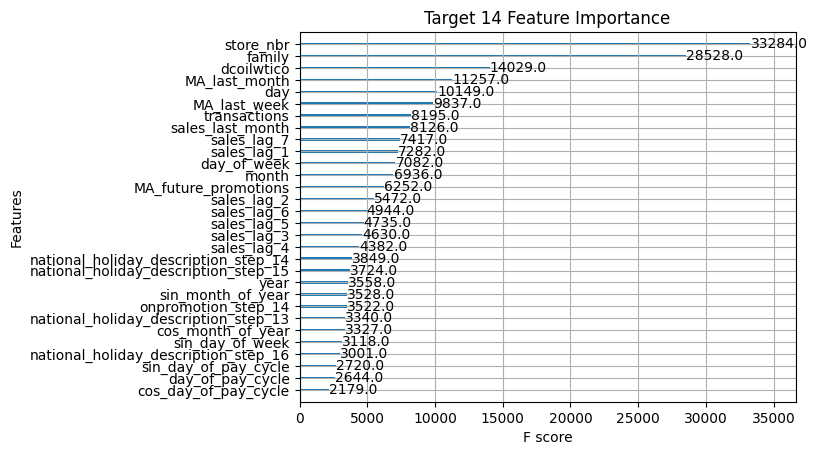

<Figure size 640x480 with 0 Axes>

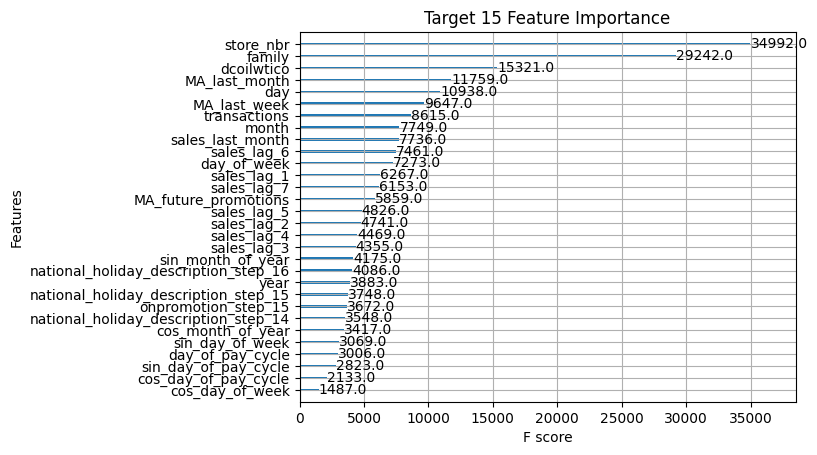

<Figure size 640x480 with 0 Axes>

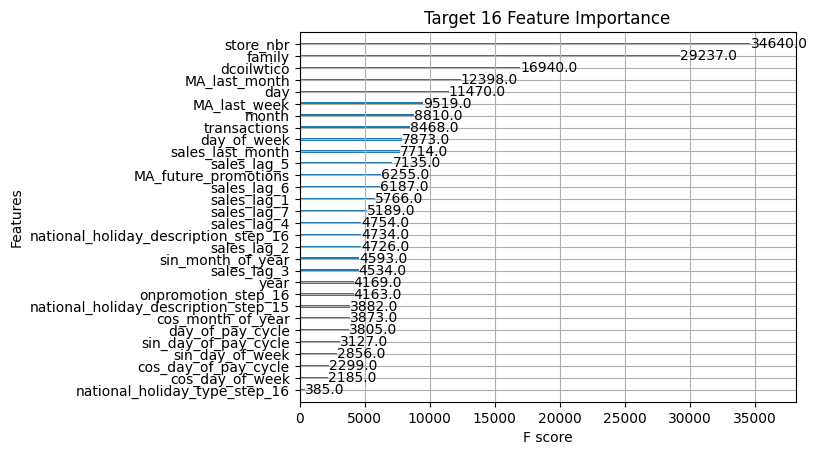

In [57]:
from xgboost import plot_importance

for i in range(1,17):
    model = models_xgb[i]
    plt.figure()
    plot_importance(model, title=f"Target {i} Feature Importance", max_num_features=30) # 
    plt.show()

**Submission**

The rest of the code is just the organization of the prediction in a format suitable for submission.

In [58]:
result_df = result_df[['id','date','store_nbr','family','avg_pred_sales','w_avg_pred_sales','xgb_pred_sales','lgbm_pred_sales','cat_pred_sales']]
result_df.to_csv('/kaggle/working/result_df.csv',index=True)
result_df.head()

,id,date,store_nbr,family,avg_pred_sales,w_avg_pred_sales,xgb_pred_sales,lgbm_pred_sales,cat_pred_sales
0,3000888,2017-08-16,1,AUTOMOTIVE,4.205252,4.211800,4.437421,4.076384,4.101951
1,3000889,2017-08-16,1,BABY CARE,0.000000,0.000000,0.000000,0.000000,0.000000
2,3000890,2017-08-16,1,BEAUTY,5.038374,5.053143,5.536747,4.799095,4.779278
3,3000891,2017-08-16,1,BEVERAGES,2211.747154,2214.247917,2312.794434,2137.400403,2185.046625
4,3000892,2017-08-16,1,BOOKS,0.072264,0.071609,0.066479,0.049733,0.100580


In [71]:
# Check submission file

chosen_pred = 'cat_pred_sales' # options: 'avg_pred_sales', 'w_avg_pred_sales','xgb_pred_sales','lgbm_pred_sales','cat_pred_sales'

to_submit = result_df[['id', chosen_pred]].rename(columns={chosen_pred:'sales'})
to_submit.head()

,id,sales
0,3000888,4.101951
1,3000889,0.000000
2,3000890,4.779278
3,3000891,2185.046625
4,3000892,0.100580


In [72]:
# Submission

to_submit.to_csv('/kaggle/working/submission.csv',index=False)

**Submission using predictions-df**

In [61]:
# # Run first 5 cells. Then:

# predictions_df = pd.read_csv('/kaggle/input/predictions-df/comparison_df (2).csv')

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 150)

# predictions_df.head()

In [62]:
# # No weights available, so excluded.

# for i in range(1,17):
#     predictions_df[f'avg_pred_sales_step_{i}'] = predictions_df[[f'xgb_pred_sales_step_{i}',
#                                                               f'lgbm_pred_sales_step_{i}',
#                                                               f'cat_pred_sales_step_{i}']].mean(axis=1)

# # Transpose predictions and join to test_df

# # Predict 0 if there were no sales in 2017 for a store_nbr, family

# comparison_df = full_df.loc[full_df['year']==2017,:]
# no_sales_2017_df = comparison_df.groupby(['store_nbr', 'family'])[['sales']].sum()
# no_sales_2017_df = no_sales_2017_df.reset_index()
# no_sales_2017_df = no_sales_2017_df.rename(columns={'sales':'sum_2017_sales'})
# no_sales_2017_df = no_sales_2017_df[no_sales_2017_df['sum_2017_sales']==0]

# predictions_df = pd.merge(left=predictions_df,
#                          right=no_sales_2017_df[['store_nbr','family','sum_2017_sales']],
#                          on=['store_nbr','family'],
#                          how='left')

# for pred_type in ('avg', 'xgb', 'lgbm', 'cat'):
#     for i in range(1,17):
#         predictions_df[f'{pred_type}_pred_sales_step_{i}'] = predictions_df['sum_2017_sales'].fillna(predictions_df[f'{pred_type}_pred_sales_step_{i}'])

# #prediction_df = comparison_df[comparison_df['date']== prediction_date]
# predictions_df = predictions_df[['store_nbr', 'family'] 
#                                 +[f'avg_pred_sales_step_{i}' for i in range(1,17)]
#                                 +[f'xgb_pred_sales_step_{i}' for i in range(1,17)]
#                                 +[f'lgbm_pred_sales_step_{i}' for i in range(1,17)]
#                                 +[f'cat_pred_sales_step_{i}' for i in range(1,17)]]

# # Merging predicted sales data from prediction_date
# result_df = test_df.reset_index()
# result_df = pd.merge(left=result_df,
#                      right=predictions_df,
#                      on=['store_nbr', 'family'],how='left')

# # Choosing i-th prediction on day i + prediction_date
# result_df['difference'] = (result_df['date']-pd.to_datetime(prediction_date)).dt.days

# for pred_type in ('avg', 'xgb', 'lgbm', 'cat'):
#     col_names = result_df['difference'].astype(str).radd(f'{pred_type}_pred_sales_step_')
#     col_codes, unique_cols = pd.factorize(col_names)
#     matrix = result_df[unique_cols].to_numpy()
#     result_df[f'{pred_type}_pred_sales'] = matrix[np.arange(len(result_df)), col_codes]

# result_df.head()

In [63]:
# # Check submission file

# chosen_pred = 'lgbm_pred_sales' # options: 'avg_pred_sales', 'w_avg_pred_sales','xgb_pred_sales','lgbm_pred_sales','cat_pred_sales'

# to_submit = result_df[['id', chosen_pred]].rename(columns={chosen_pred:'sales'})
# to_submit.head()

In [64]:
# # Submission

# to_submit.to_csv('/kaggle/working/submission.csv',index=False)